In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value
import networkx as nx
pulp.list_solvers(onlyAvailable=True)

No parameters matching '_test' found


['GUROBI', 'PULP_CBC_CMD']

In [29]:
n_point=10
np.random.seed(2002)

df=pd.DataFrame({
    'x':np.random.randint(0, 100, n_point),
    'y':np.random.randint(0, 100, n_point),
})

df.iloc[0]['x']=0
df.iloc[0]['y']=0

df

,x,y
0,0,0
1,18,57
2,8,75
3,73,59
4,44,22
5,56,7
6,13,69
7,87,83
8,4,70
9,25,90


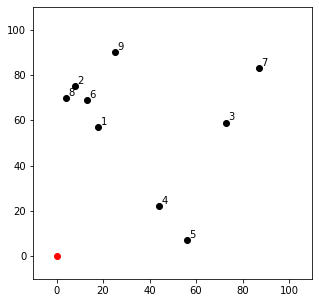

In [30]:
plt.figure(figsize=(5, 5))
#plt.scatter(df['x'], df['y'])

# draw color depending on index
for i, row in df.iterrows():
    if i==0:
        plt.scatter(row['x'], row['y'], color='r')
    else:
        plt.scatter(row['x'], row['y'], color='black')
        plt.text(row['x']+1, row['y']+1, f'{i}')
        

plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.show()

In [31]:
df[['x', 'y']].values

array([[ 0,  0],
       [18, 57],
       [ 8, 75],
       [73, 59],
       [44, 22],
       [56,  7],
       [13, 69],
       [87, 83],
       [ 4, 70],
       [25, 90]])

In [32]:
d=distance_matrix(df[['x', 'y']].values, df[['x', 'y']].values, p=2)  # euclidean

In [33]:
d[1][0]==d[0][1]

True

In [101]:
model=LpProblem(name='tsp_no_subtour', sense=LpMinimize)

In [102]:
#for yeah in ((i, j) for i in range(n_point) for j in range(n_point) if i!=j):
#    print(yeah)
x=LpVariable.dicts('x', ((i, j) for i in range(n_point) for j in range(n_point) if i!=j), cat='Binary')

In [103]:
u=LpVariable.dicts('u', (i for i in range(n_point)), lowBound=1, upBound=n_point-1, cat='Integer')  # sequence

In [104]:
# constraint
for i in range(n_point):
    model+=lpSum(x[j, i] for j in range(n_point) if j!=i) == 1  # ขาเข้า
    model+=lpSum(x[i, j] for j in range(n_point) if j!=i) == 1  # ขาออก

In [105]:
## x[0,4] = 1 then u[4] > u[0]
## x[i,j] = 1 then u[j]-u[i] >= 1
## x[i,j] = 0 then 9-1 = 8, 1-9 = -8 (ค่าลบที่น้อยที่สุด มี 10 nodes upBound = 10-1 = 9) เทอมนี้มีค่าเป็นเท่าไรก็ได้

for i in range(n_point):
    for j in range(n_point):
        if i!=j and (i!=0 and j!=0):  # ระวัง u[0] ตอนขากลับมาจุดเริ่มต้น
            model+=(u[j]-u[i] >= 1-(n_point-1)*(1-x[i, j]))

In [106]:
# objective function
model+=lpSum(x[i, j]*d[i][j] for i in range(n_point) for j in range(n_point) if i!=j)

In [107]:
status=model.solve()
status

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/panithi/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/61077d915cd84fe98ad17193edb9e867-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/61077d915cd84fe98ad17193edb9e867-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 97 COLUMNS
At line 782 RHS
At line 875 BOUNDS
At line 984 ENDATA
Problem MODEL has 92 rows, 99 columns and 396 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 274.619 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 72 streng

1

In [108]:
model.objective.value()

323.73926599128

In [109]:
from ast import literal_eval as make_tuple

route=[]
for var in model.variables():
    if var.name[0] == 'x' and var.value() == 1:
        a=var.name
        a=a.replace('x', '')
        a=a.replace('_', '')
        route.append(make_tuple(a))
        #print(var.name, var.value())
route

[(0, 1),
 (1, 6),
 (2, 9),
 (3, 4),
 (4, 5),
 (5, 0),
 (6, 8),
 (7, 3),
 (8, 2),
 (9, 7)]

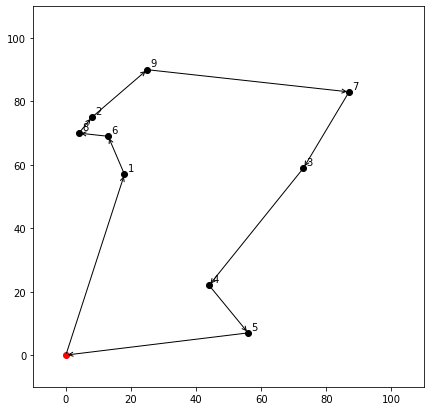

In [110]:
plt.figure(figsize=(7, 7))
# draw color depending on index
for i, row in df.iterrows():
    if i==0:
        plt.scatter(row['x'], row['y'], color='r')
    else:
        plt.scatter(row['x'], row['y'], color='black')
        plt.text(row['x']+1, row['y']+1, f'{i}')
        
arrowprops=dict(arrowstyle='->')
for i, j in route:
    plt.annotate('', xy=[df.iloc[j]['x'], df.iloc[j]['y']], xytext=[df.iloc[i]['x'], df.iloc[i]['y']], arrowprops=arrowprops)

plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.show()

In [111]:
for var in model.variables():
    if var.name[0] == 'u':
        print(var.name, var.value())
        
model

u_1 1.0
u_2 4.0
u_3 7.0
u_4 8.0
u_5 9.0
u_6 2.0
u_7 6.0
u_8 3.0
u_9 5.0


tsp_no_subtour:
MINIMIZE
59.77457653551382*x_(0,_1) + 75.4254598925323*x_(0,_2) + 93.86160024205851*x_(0,_3) + 49.193495504995376*x_(0,_4) + 56.43580423808985*x_(0,_5) + 70.21395872616783*x_(0,_6) + 120.24142381059865*x_(0,_7) + 70.11419257183242*x_(0,_8) + 93.40770846134703*x_(0,_9) + 59.77457653551382*x_(1,_0) + 20.591260281974*x_(1,_2) + 55.036351623268054*x_(1,_3) + 43.60045871318328*x_(1,_4) + 62.80127387243033*x_(1,_5) + 13.0*x_(1,_6) + 73.7360156233031*x_(1,_7) + 19.1049731745428*x_(1,_8) + 33.734255586866*x_(1,_9) + 75.4254598925323*x_(2,_0) + 20.591260281974*x_(2,_1) + 66.94027188471824*x_(2,_3) + 64.07027391856539*x_(2,_4) + 83.23460818673925*x_(2,_5) + 7.810249675906654*x_(2,_6) + 79.40403012442127*x_(2,_7) + 6.4031242374328485*x_(2,_8) + 22.67156809750927*x_(2,_9) + 93.86160024205851*x_(3,_0) + 55.036351623268054*x_(3,_1) + 66.94027188471824*x_(3,_2) + 47.01063709417264*x_(3,_4) + 54.70831746635972*x_(3,_5) + 60.8276253029822*x_(3,_6) + 27.784887978899608*x_(3,_7) + 69.8713